In [1]:
import pandas as pd
from scripts.evaluate_model import ModelEvaluator
from sklearn.model_selection import train_test_split
from tabpfn import TabPFNRegressor


data = pd.read_csv('../data/processed/dataset_reduced.csv')
data

,Z,Period,Group,EN,CR,CM_type,CM_morph,MS2_morph,CP_morph,SSA,C,Cation,Anion,PW,CD,Cs
0,23,4,5,1.63,1.44,0,0,1,0,5.5,6.0,K,OH,0.5,1.0,152.0
1,23,4,5,1.63,1.44,0,0,1,0,5.5,6.0,K,OH,0.5,2.0,145.0
2,23,4,5,1.63,1.44,0,0,1,0,5.5,6.0,K,OH,0.5,5.0,136.0
3,23,4,5,1.63,1.44,0,0,1,0,5.5,6.0,K,OH,0.5,10.0,120.0
4,23,4,5,1.63,1.44,0,0,1,0,5.5,6.0,K,OH,0.5,15.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,74,6,6,1.70,1.50,1,1,2,1,10.8,1.0,K,OH,0.5,1.0,600.0
578,74,6,6,1.70,1.50,1,1,2,1,10.8,1.0,K,OH,0.5,2.0,527.0
579,74,6,6,1.70,1.50,1,1,2,1,10.8,1.0,K,OH,0.5,4.0,476.0
580,74,6,6,1.70,1.50,1,1,2,1,10.8,1.0,K,OH,0.5,8.0,391.0


In [2]:
# 对 Cation, Anion 进行One-hot编码
data_encoded = pd.get_dummies(data, columns=['Cation', 'Anion'])

# 划分训练集和测试集
data_encoded['target_class'] = pd.qcut(data_encoded['Cs'], q=10, labels=False)
X = data_encoded.drop(['Cs', 'target_class'], axis=1)
y = data_encoded['Cs']
stratify_column = data_encoded['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=stratify_column)
X_train

,Z,Period,Group,EN,CR,CM_type,CM_morph,MS2_morph,CP_morph,SSA,C,PW,CD,Cation_H,Cation_K,Cation_Li,Cation_Na,Anion_OH,Anion_SO4
434,42,5,6,2.16,1.46,0,0,1,0,21.10,1.0,1.00,1.5,False,False,False,True,False,True
519,50,5,14,1.96,1.40,2,2,3,1,41.82,2.0,0.45,0.3,False,True,False,False,True,False
172,27,4,9,1.88,1.18,3,3,3,4,253.80,6.0,0.50,1.0,False,True,False,False,True,False
165,42,5,6,2.16,1.46,0,0,2,0,58.20,2.0,0.50,2.0,False,True,False,False,True,False
76,26,4,8,1.83,1.24,2,2,3,1,135.00,2.0,1.10,20.0,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,28,4,10,1.91,1.17,3,3,5,3,24.00,2.0,0.40,15.0,False,True,False,False,True,False
320,28,4,10,1.91,1.17,1,1,2,1,72.60,3.0,0.40,5.0,False,True,False,False,True,False
531,74,6,6,1.70,1.50,0,0,3,0,16.64,2.0,0.60,6.0,False,True,False,False,True,False
150,27,4,9,1.88,1.18,0,0,5,0,113.90,2.0,0.50,1.0,False,True,False,False,True,False


In [3]:
# 初始化TabPFN回归模型
model = TabPFNRegressor()

# 训练模型
model.fit(X_train, y_train)

# 预测
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [4]:
evaluator = ModelEvaluator(model_name='TabPFN', y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_test_pred=y_test_pred)
df_metrics = evaluator.metrics_to_dataframe()
df_metrics.to_csv('../results/reports/metrics_TabPFN.csv', index=False)
df_metrics

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,TabPFN,0.999,7.72,2.63,12.46,0.986,25.07,7.22,44.53


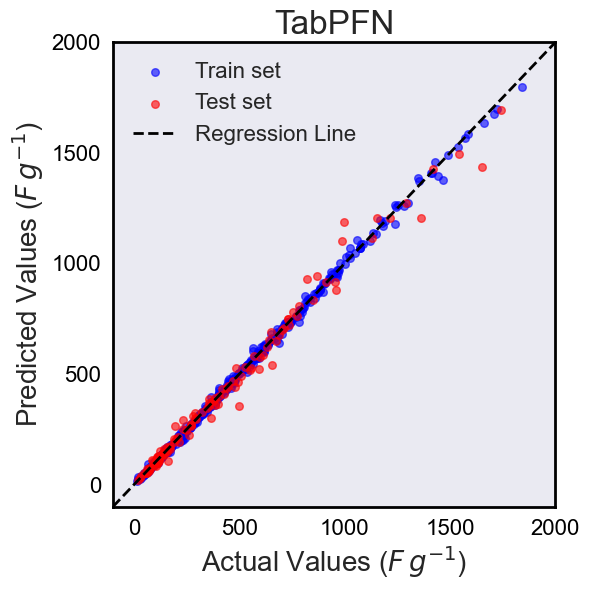

In [5]:
figpath = '../results/figures/avp_TabPFN.png'
evaluator.plot_actual_vs_predicted(figpath=figpath)

In [6]:
# Z, Period 与 CR 的相关系数过高，特征冗余
# 删除 Z, Period
X_train_r = X_train.drop(columns=['Z', 'Period'])
X_test_r = X_test.drop(columns=['Z', 'Period'])

# 初始化TabPFN回归模型
model_r = TabPFNRegressor()

# 重新训练模型
model_r.fit(X_train_r, y_train)

# 重新预测
y_train_r_pred = model_r.predict(X_train_r)
y_test_r_pred = model_r.predict(X_test_r)

# 重新评估
evaluator_r = ModelEvaluator(model_name='TabPFN', y_train=y_train, y_train_pred=y_train_r_pred, y_test=y_test, y_test_pred=y_test_r_pred)

df_metrics_r = evaluator_r.metrics_to_dataframe()
df_metrics_r.to_csv('../results/reports/metrics_TabPFN_r.csv', index=False)
df_metrics_r

,model,R2_train,MAE_train,MAPE_train,RMSE_train,R2_test,MAE_test,MAPE_test,RMSE_test
0,TabPFN,0.999,8.18,2.75,13.51,0.981,29.34,8.55,52.85


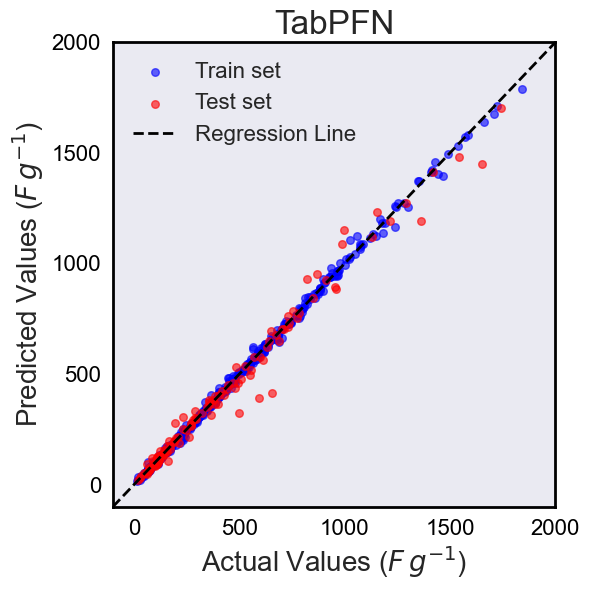

In [7]:
figpath = '../results/figures/avp_TabPFN_r.png'

evaluator_r.plot_actual_vs_predicted(figpath=figpath)